In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cmcrameri import cm as  cmc
import matplotlib as mpl
import pandas as pd
import xarray as xr
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_plots as mp
import model1_explore as me
import model1 as mod1
from scipy.stats import norm, beta
from statsmodels.base.model import GenericLikelihoodModel
import palettable as pal

import Utilities as util


In [2]:
loc_model = '../mod/model1/'
loc_fig = '../fig/model1/'

# read data
# explorative
# 0. overview
ds_c = xr.open_dataset(loc_model + 'expl_hist_clouds.nc')
T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)



# 1. cs -> cs

# 2. c -> cs
ds_local = xr.open_dataset(loc_model + 'expl_local_param.nc')

# 3. cs -> c
ds_cs_c = xr.open_dataset(loc_model + 'expl_hist_cs_to_c.nc')

# 4. c -> c
df = pd.read_csv(loc_model + 'expl_example_bin_data.csv')
df_bin_fit = pd.read_csv(loc_model + 'expl_examble_bin_fit.csv')
# ds_local local param 

# global model1
# df_glob_c_to_c_cod = pd.read_csv(loc_model + 'glob_c_to_c_cod.csv')
# ds_theta = xr.open_dataset(loc_model + 'glob_theta.nc')




In [4]:
T_total

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
from,,,,,,,,,,
1.0,0.730911,0.162792,0.019065,0.024130,0.049494,0.006002,0.007418,0.000140,0.000027,0.000019
2.0,0.187266,0.521912,0.064281,0.030758,0.170430,0.018894,0.006035,0.000329,0.000072,0.000023
3.0,0.061743,0.201002,0.322074,0.155468,0.083507,0.127773,0.046862,0.000589,0.000709,0.000272
4.0,0.043428,0.029331,0.082986,0.675343,0.006545,0.018844,0.143056,0.000086,0.000050,0.000331
5.0,0.130768,0.345131,0.026221,0.005378,0.424644,0.043641,0.006978,0.014525,0.002483,0.000231
6.0,0.011424,0.062450,0.150183,0.025300,0.144633,0.458006,0.072189,0.010266,0.057070,0.008479
7.0,0.005970,0.006191,0.020488,0.196476,0.014017,0.056780,0.613569,0.002970,0.005599,0.077940
8.0,0.065952,0.150179,0.009932,0.005364,0.496027,0.054033,0.015693,0.172229,0.026818,0.003774
9.0,0.001075,0.002031,0.012545,0.001434,0.032736,0.402389,0.057109,0.033453,0.386858,0.070370


## 0. Cloud distribution

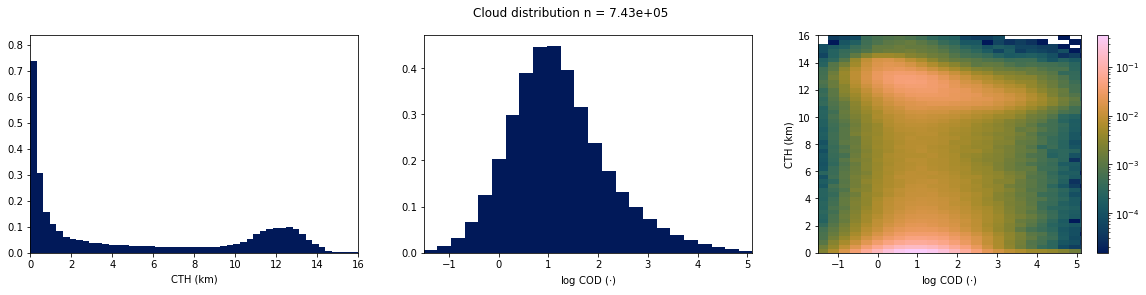

In [6]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=2, n=16)

dedges, hedges, freq = ds_c.dedges.data, ds_c.hedges.data, ds_c.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
fig.savefig(loc_fig + 'expl_cloud_distr.png')

# .colorbrewer.sequential import Blues_8
# ax.imshow(data, cmap=Blues_8.mpl_colormap)


In [23]:
T = T_total#.iloc[:-1]
print(T.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T = T.rename(
            columns = classes, 
             index = classes
            )
T

loc_model1 = '../mod/model1/'
T_total_data = pd.read_csv(loc_model1 + 'expl_transition_ctypes.csv', index_col = 0)
T_data = T_total_data#.iloc[:-1]

print(T_data.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T_data = T_data.rename(
            columns = classes, 
             index = classes
            ).drop(['invalid pixel'], axis = 1).drop(['invalid pixel'])
T_data.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')

T_diff = (T_data - T)


import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)



T_diff.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')
# classes

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       'All'],
      dtype='object', name='from')
Index(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', 'All'],
      dtype='object', name='from')


,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.02,-0.04,-0.00,0.04,-0.01,-0.00,0.01,0.00,0.00,0.00
cumulus,-0.01,0.00,-0.00,0.03,-0.02,-0.00,0.00,0.00,0.00,0.00
altocumulus,-0.00,-0.07,0.06,0.04,-0.05,0.02,-0.01,0.00,0.00,0.00
cirrus,0.03,0.01,-0.02,0.00,0.00,-0.01,-0.03,0.00,0.00,0.00
stratocumulus,-0.02,-0.04,0.00,0.02,0.01,0.00,0.02,0.01,0.00,0.00
altostratus,-0.00,-0.03,-0.02,0.01,-0.09,0.11,0.02,-0.01,0.00,0.00
cirrostratus,0.02,0.00,-0.00,-0.04,-0.00,-0.01,0.05,-0.00,-0.00,-0.01
stratus,-0.04,-0.03,0.00,0.00,-0.03,0.01,0.01,0.05,0.02,0.00
nimbostratus,0.00,0.00,0.01,0.00,-0.01,-0.06,0.00,-0.02,0.06,-0.00


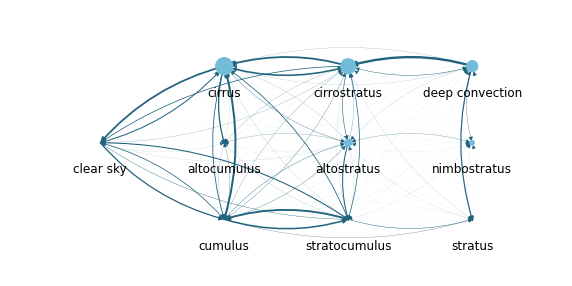

In [22]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

T = T_diff

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}

node_size = T.loc['All', node_names] * 5000
edge_widths = [w * T.loc['All',edge[0]] * 1000 for (*edge, w) in G.edges.data('weight')] # weight * node size
labels = {item:item for item in node_names}

fig = plt.figure(figsize = (10, 5))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size = node_size,
        node_color =  '#72BCD9',
#         alpha = 0,
)

nx.draw_networkx_edges(G, pos, width=edge_widths,
                       node_size = node_size,
                       edge_color = '#21637D',
                       connectionstyle='arc3, rad=.15'
 )

pos_labels = {k: v + [0, -.35] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels, font_color = 'black')
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)

plt.savefig(loc_fig + 'graph_diff.png', transparent=True)

In [9]:
# edge_widths = [(w * 10 , print(T.loc['All',edge[0]])) for (*edge, w) in G.edges.data('weight')]


# 1. Clear sky to Clear sky

In [10]:
# no exploration needed
ds_local.p_cscs

0.7309056818093408

# 2. Cloud to clear sky

In [11]:
dh = ds_local.dh
dd = ds_local.dd
mu_h = ds_local.mu_h # m
mu_d = ds_local.mu_d
n_h = len(mu_h)
n_d = len(mu_d)

ds_local

<xarray.Dataset>
Dimensions:  (mu_d: 19, mu_h: 53)
Coordinates:
  * mu_h     (mu_h) float64 150.0 450.0 750.0 ... 1.515e+04 1.545e+04 1.575e+04
  * mu_d     (mu_d) float64 -1.0 -0.7 -0.4 -0.1 0.2 0.5 ... 3.2 3.5 3.8 4.1 4.4
Data variables: (12/14)
    p_cs     (mu_h, mu_d) float64 ...
    n_c      (mu_h, mu_d) float64 ...
    mu       (mu_h, mu_d) float64 ...
    sigma    (mu_h, mu_d) float64 ...
    n_cc     (mu_h, mu_d) float64 ...
    alpha    (mu_h, mu_d) float64 ...
    ...       ...
    beta1    (mu_h, mu_d) float64 ...
    alpha2   (mu_h, mu_d) float64 ...
    beta2    (mu_h, mu_d) float64 ...
    p        (mu_h, mu_d) float64 ...
    conv_b   (mu_h, mu_d) float64 ...
    conv_mb  (mu_h, mu_d) float64 ...
Attributes:
    dh:       300
    dd:       0.3
    p_cscs:   0.7309056818093408

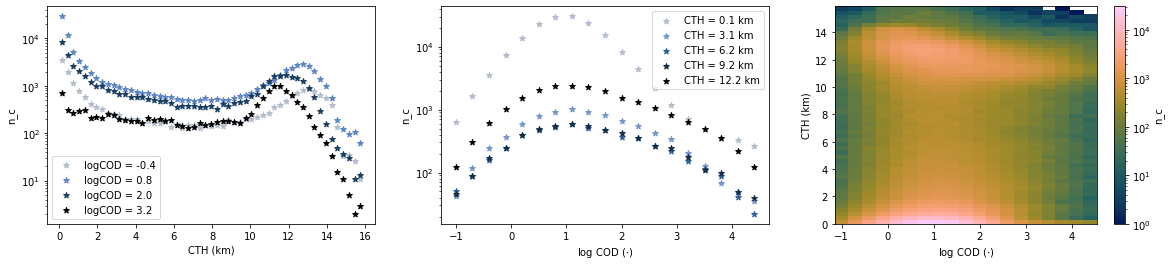

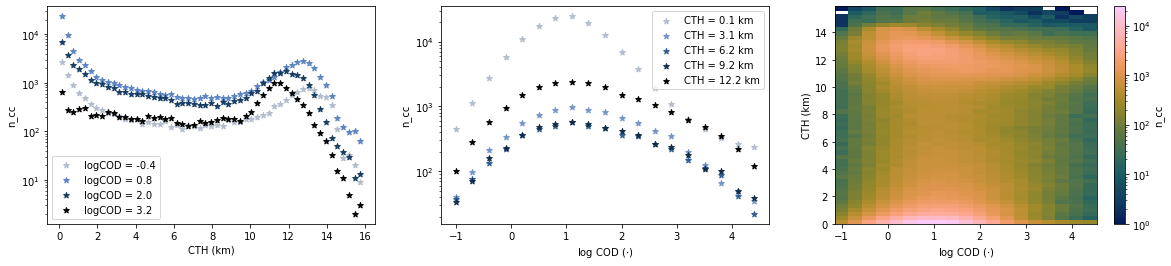

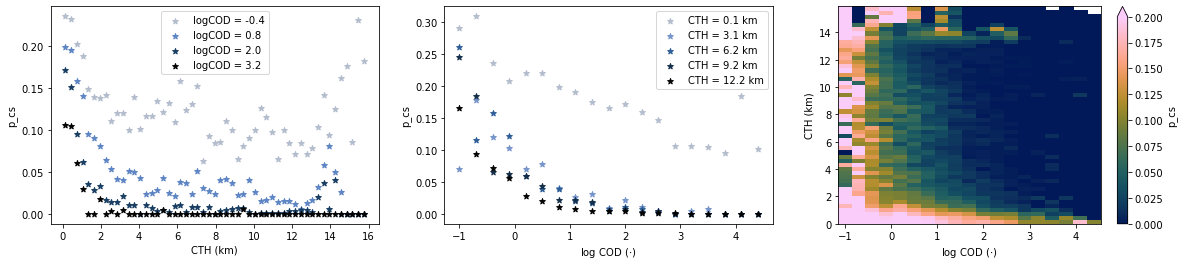

In [12]:
fig, ax = mp.plotLocalParam(ds_local.n_c, logscale = True)
fig.savefig(loc_fig + 'expl_local_n_c.png')

fig, ax = mp.plotLocalParam(ds_local.n_cc, logscale = True)
fig.savefig(loc_fig + 'expl_local_n_cc.png')

fig, ax = mp.plotLocalParam(ds_local.p_cs, logscale = False, vmax = .2)
fig.savefig(loc_fig + 'expl_local_p_cs.png')

# 3. Clear sky to Cloud

NameError: name 'ds_theta' is not defined

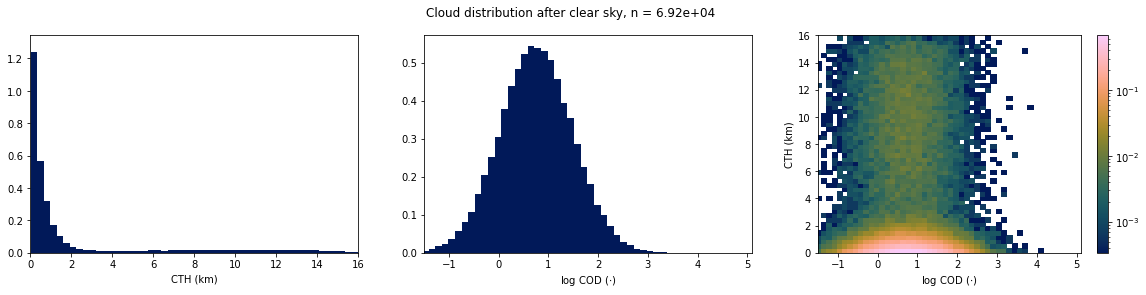

In [14]:
freq = ds_cs_c.freq.data

fig, ax = mp.plotCloudHist_f(ds_cs_c.dedges.data, ds_cs_c.hedges.data, ds_cs_c.freq.data,
                          title = f'Cloud distribution after clear sky, n = {ds_cs_c.freq.data.sum().sum():.2e}',
                         density = True)
theta = ds_theta.theta3
mp.plotCTHBeta(ax[0], *theta[0:2])
mp.plotCTHBetaMix(ax[0], *theta[2:7].data)
mp.plotCODNormal(ax[1], *theta[7:9])

fig.savefig(loc_fig + 'expl_cs_cloud_distr_3.png')
theta



# 4. Cloud to Cloud

1000.0 0.0


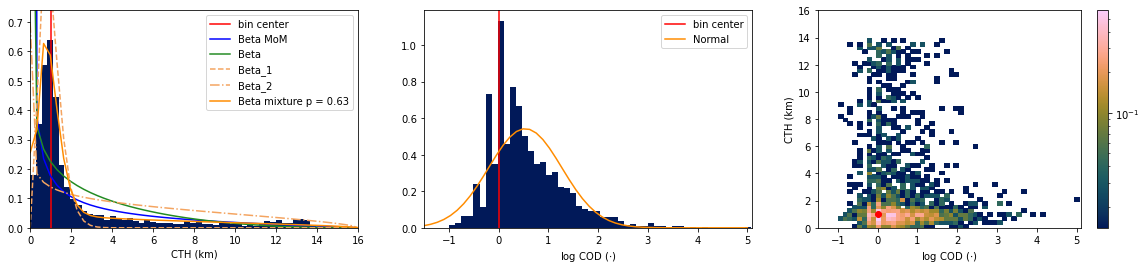

In [27]:
hlim = mp.hlim
dlim = mp.dlim

fits = []
fits_sb = []

coef = np.zeros((len(df_bin_fit), 5))
bse = np.zeros((len(df_bin_fit), 5))

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
    print(h,d)
    
    fig , ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint

    # bin centers
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')

    
    fit = me.fitMixBetaCTH(df_bin.h_t_next)
    coef[idx, :] = fit.params
    bse[idx, :] = fit.bse
    fits.append(fit)
    
    fit_sb = me.fitBetaCTH(df_bin.h_t_next)
    fits_sb.append(fit_sb)
    
    # fits
    # cod
    mom = MoM_sb(ml.CTHtoUnitInt(df_bin.h_t_next))
    mp.plotCTHBeta(ax[0], *mom, label = 'Beta MoM', color = 'blue')
    mp.plotCTHBeta(ax[0], param.alpha, param.beta)
    mp.plotCTHBetaMix(ax[0], param.alpha1, param.beta1, param.alpha2, param.beta2, param.p.values[0])
    mp.plotCODNormal(ax[1], param.mu, param.sigma)
    
    fig.savefig(loc_fig + f'expl_bins{idx}.png')
    if idx == 0:
        break

In [12]:
i = 0
def AIC(k, L):
    ### L maximized log likelihood
    return 2 * k - 2 * L

def BIC(k, L, n):
    ### L maximized log likelihood
    return k * np.log(n) - 2 * L

def MoM_sb(x):
    m1 = x.mean()
    m2 = (x**2).mean()
    alpha = m1 * (m1 - m2) /(m2 - m1**2)
    beta = (m1/m2 - 1) * (alpha +1)
    return alpha , beta

mom = np.zeros((len(df_bin_fit),2))

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    
    mom[idx,:] = MoM_sb(ml.CTHtoUnitInt(df_bin.h_t_next))
#     print(mom)
    
    
for fit_mb, fit_sb in zip(fits, fits_sb) :
#     print(fit.summary())
    print(i)
    print(fit_mb.llf, fit_sb.llf)
    print(AIC(5, fit_mb.llf), AIC(2, fit_sb.llf))
    print(BIC(5, fit_mb.llf, fit_mb.nobs), BIC(2, fit_sb.llf, fit_sb.nobs))
    print(fit_sb.params)
    print(fit_sb.params - 2*fit_sb.bse, 'lower')
    print(fit_sb.params + 2*fit_sb.bse, 'upper')
    print(mom[i,:])
# dir(fit)
    
    i+=1



0
2266.387012264334 1590.3209115258328
-4522.774024528668 -3176.6418230516656
-4494.494704440587 -3165.3300950164335
[0.70157982 3.20807975]
[0.66463046 2.99193128] lower
[0.73852918 3.42422823] upper
[0.35109509 1.84597849]
1
82.83677654775809 50.038091790595814
-155.67355309551618 -96.07618358119163
-132.99009510755965 -87.00280038600901
[1.07361062 1.57566085]
[0.96868705 1.41131874] lower
[1.17853418 1.74000296] upper
[1.16347904 1.61073911]
2
156.3402521132474 11.599852355797756
-302.6805042264948 -19.199704711595512
-279.06735525221757 -9.754445121884615
[1.21749642 1.24273732]
[1.10620389 1.12872692] lower
[1.32878894 1.35674771] upper
[1.4364299  1.26319662]
3
3815.5441476762367 1179.343243839315
-7621.088295352473 -2354.68648767863
-7589.733111023508 -2342.144413947044
[3.38448618 1.74975639]
[3.23243073 1.6762441 ] lower
[3.53654163 1.82326868] upper
[3.95218239 1.75675123]
4
9454.30026258527 7202.944541565868
-18898.60052517054 -14401.889083131737
-18865.528925659804 -14388.

In [13]:
fit.llf, fit.summary()
dir(fit)
fit.to_netcdf()

AttributeError: 'GenericLikelihoodModelResults' object has no attribute 'to_netcdf'

In [26]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             MyMixBetaML Results                              
==============================================================================
Dep. Variable:               h_t_next   Log-Likelihood:                 7296.1
Model:                    MyMixBetaML   AIC:                        -1.459e+04
Method:            Maximum Likelihood   BIC:                        -1.458e+04
Date:                Fri, 21 Jan 2022                                         
Time:                        17:44:54                                         
No. Observations:                3724                                         
Df Residuals:                    3723                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha1       227.5649      7.889     28.845      0.000     212.102     243.028
beta1         77.0238      2.659     28.964      0.000      71.812      82.236
alpha2         4.4945      0.417     10.776      0.000       3.677       5.312
beta2          2.6282      0.215     12.238      0.000       2.207       3.049
p              0.9199      0.007    138.178      0.000       0.907       0.933
==============================================================================
"""

## local behaviour parameters

## cod

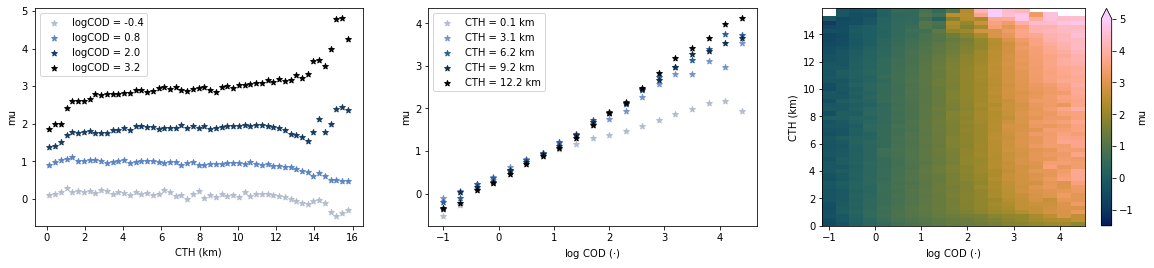

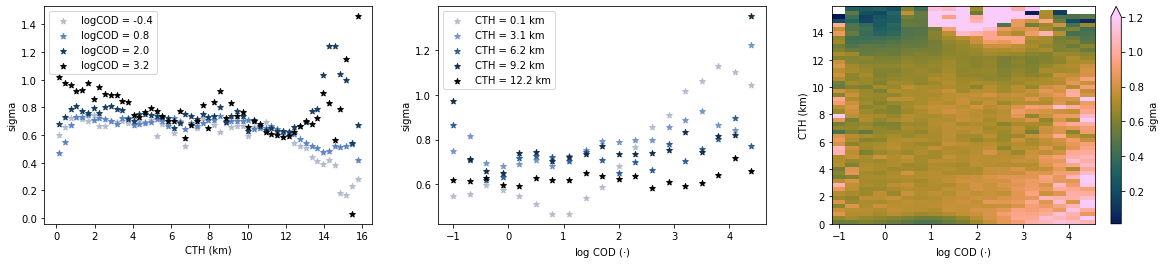

In [16]:

fig, ax = mp.plotLocalParam(ds_local.mu, vmin = -1.5, vmax = 5)
fig.savefig('../fig/model1/expl_local_mu.png')

fig, ax = mp.plotLocalParam(ds_local.sigma, vmax = 1.2)
fig.savefig('../fig/model1/expl_local_sigma.png')

## CTH

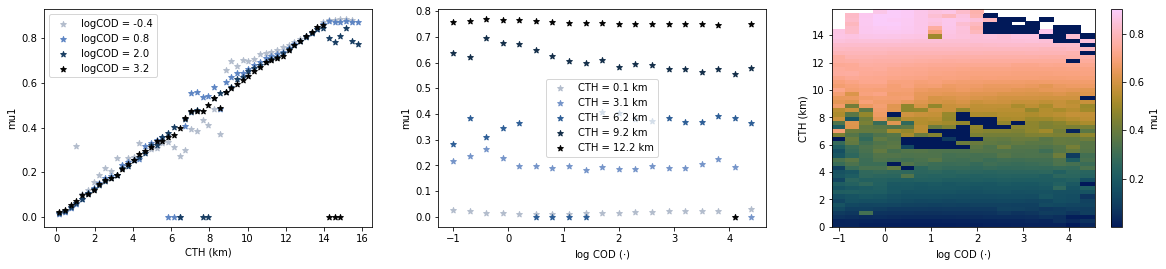

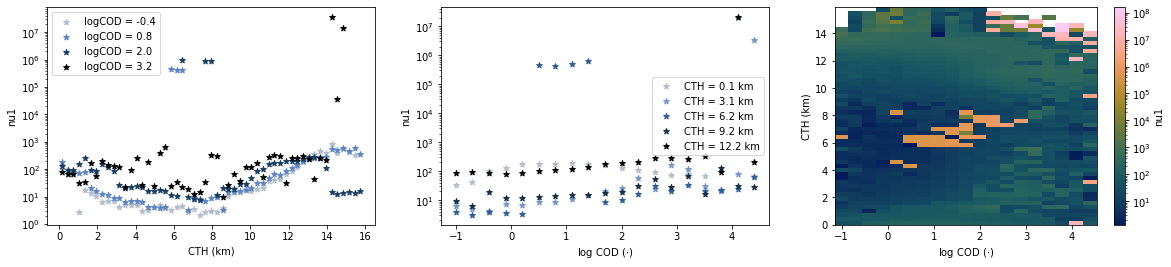

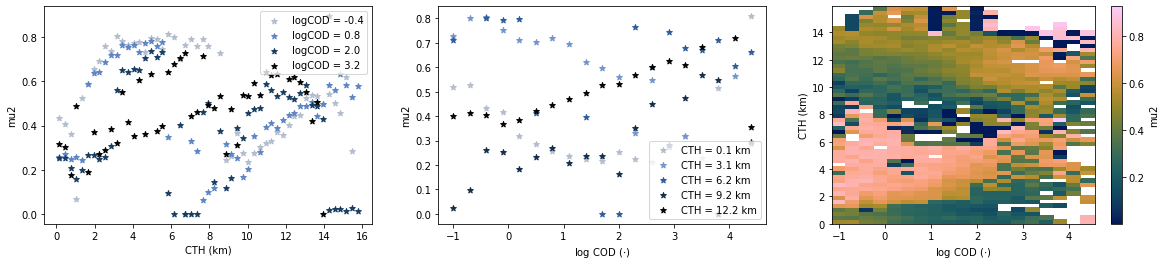

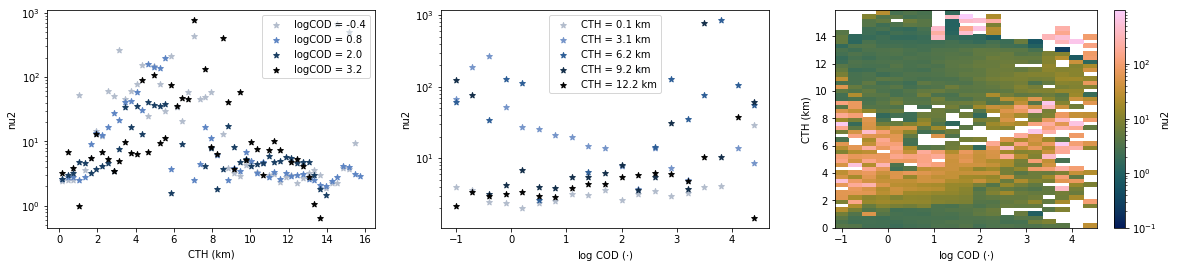

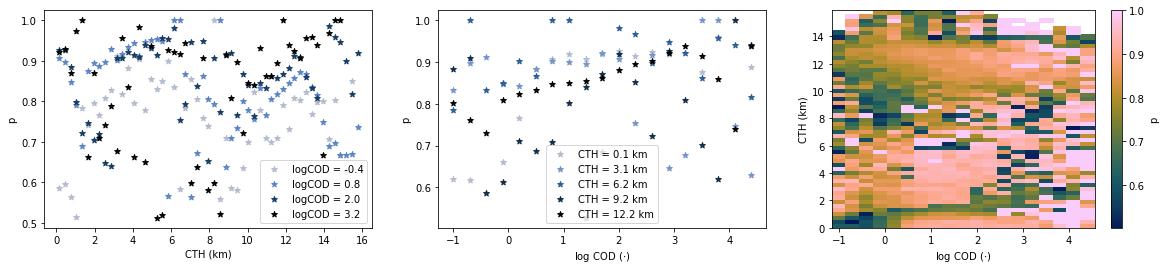

In [17]:
mu1 = me.meanBeta(ds_local.alpha1, ds_local.beta1).rename('mu1')
nu1 = (ds_local.alpha1 + ds_local.beta1).rename('nu1')
mu2 = me.meanBeta(ds_local.alpha2, ds_local.beta2).rename('mu2')
nu2 = (ds_local.alpha2 + ds_local.beta2).rename('nu2')

fig, ax = mp.plotLocalParam(mu1)
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(nu1, logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(mu2)
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(nu2, logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p)
fig.savefig(loc_fig + 'expl_local_p.png')


Text(0.5, 0.98, 'Estimators of time distribution COD')

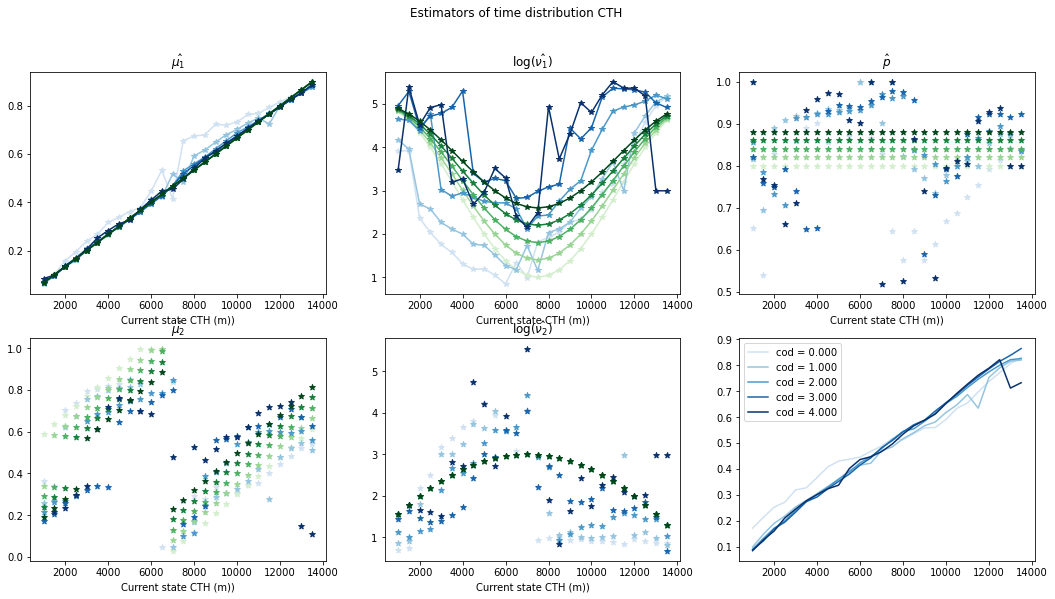

C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


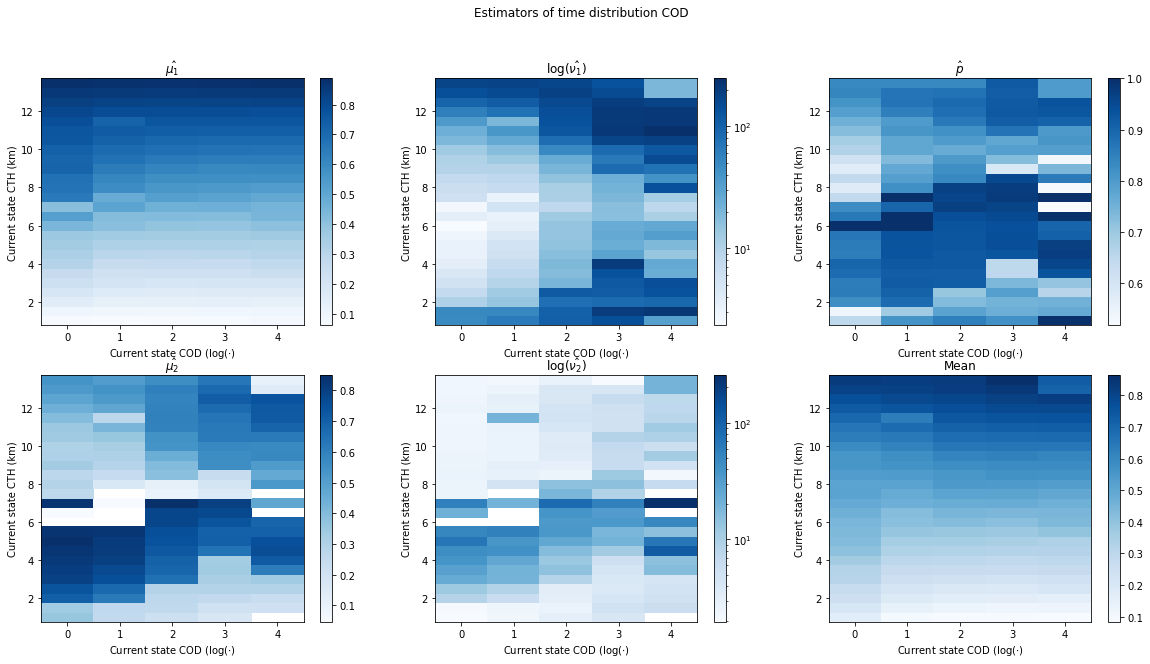

## clear sky to cloud

## cloud to clear sky